In [1]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.preprocessing import StandardScaler
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import glob
import re
import joblib
from tqdm import tqdm
import shap

In [2]:
clinical_info_path = '../data/NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv'
df = pd.read_csv(clinical_info_path)
# df['clinical.T.Stage'] = df['clinical.T.Stage'].astype('int64')

In [3]:
with open('../data/manifest-1603198545583/NSCLC-Radiomics/feature_names.txt', 'r') as f:
    feature_name = [name.strip('\n') for name in f.readlines()]
patient_id = []
feature_matrix = []
feature_path = glob.glob('../data/manifest-1603198545583/NSCLC-Radiomics/*/*/CT_features*')
for path in feature_path:
    with open(path, 'rb') as f:
        feature_dict = joblib.load(f)
    feature_matrix.append(
        np.array([feature_dict[name] for name in feature_name])      
    )
    patient_id.append(
        path.split('/')[4]
    )

In [4]:
feature_matrix = np.stack(feature_matrix)

In [5]:
feature_matrix.shape

(420, 1223)

In [80]:
## choose whether to use z-score normalization
mean = np.mean(feature_matrix, axis=0, keepdims=True)
std = np.std(feature_matrix, axis=0, keepdims=True)
feature_matrix = (feature_matrix - mean) / std

In [81]:
filtered_df = df[df['PatientID'].isin(patient_id)]
sorted_df = filtered_df.set_index('PatientID').loc[patient_id].reset_index()

In [82]:
feature_df = pd.DataFrame(feature_matrix, columns=feature_name)

In [102]:
dataset = pd.concat([sorted_df, feature_df], axis=1)

In [103]:
## checkout nan value
X_label = ['age', 'gender',"clinical.T.Stage","Clinical.N.Stage","Clinical.M.Stage","Overall.Stage"] + feature_name
X_dataset = dataset[X_label]
for label in X_label:
    nan_num = dataset[label].isnull().sum()
    if nan_num > 0:
        print(label, nan_num)

age 22
clinical.T.Stage 1
Overall.Stage 1


In [104]:
## the dataset contains a few nan values, remove t.
dataset.dropna(subset = [column for column in X_label], inplace= True)

In [105]:
dataset['clinical.T.Stage'] = dataset['clinical.T.Stage'].astype('int64')
ordinal_mapping = {'Overall.Stage': {'I': 1, 'II': 2, 'IIIa': 3, 'IIIb': 4}}
for column, mapping in ordinal_mapping.items():
        dataset[column] = dataset[column].map(mapping)
categorical_columns = ['gender']  
dataset = pd.get_dummies(dataset, columns=categorical_columns, drop_first=True)

In [106]:
dataset.head()
X_label = np.array(['age', 'gender_male',"clinical.T.Stage","Clinical.N.Stage","Clinical.M.Stage","Overall.Stage"] + feature_name)

In [107]:
X = dataset[X_label].to_numpy()
Y = dataset[['deadstatus.event','Survival.time']].to_numpy()
structured_Y = np.zeros(Y.shape[0], dtype = [('event', bool), ('time', float)])
structured_Y['event'] = Y[:, 0].astype(bool)
structured_Y['time'] = Y[:, 1] 
Y = structured_Y

In [108]:
## feature selection
lasso_cox = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=np.logspace(-2, 0, 20))
lasso_cox.fit(X, Y)
print((lasso_cox.coef_ != 0).all(axis=1).sum())
selected_X_label = X_label[(lasso_cox.coef_ != 0).all(axis=1)]
X = dataset[selected_X_label].to_numpy()

35


In [16]:
## random forest
kf = KFold(n_splits=5, shuffle=True, random_state=23)
c_index_scores = []

best_c_index = -np.inf
best_model = None

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    model = RandomSurvivalForest(n_estimators=100, min_samples_split=5, random_state=32)
    model.fit(X_train, y_train)
    risk_scores = model.predict(X_test)

    c_index = concordance_index_censored(
        y_test["event"], y_test["time"], risk_scores
    )[0] 
    c_index_scores.append(c_index)
    
    print(f"C-index for fold: {c_index:.3f}")
    if c_index > best_c_index:
        best_c_index = c_index
        best_model = model

average_c_index = np.mean(c_index_scores)
print(f"\nAverage C-index across 5 folds: {average_c_index:.3f}")

print("\nRunning SHAP analysis on the best model...")

explainer = shap.Explainer(best_model.predict, X) 
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

C-index for fold: 0.615
C-index for fold: 0.599
C-index for fold: 0.584
C-index for fold: 0.609
C-index for fold: 0.637

Average C-index across 5 folds: 0.609

Running SHAP analysis on the best model...


In [73]:
results = pd.DataFrame({
    "risk_score": risk_scores,
    "time": y_test["time"],  
    "event": y_test["event"], 
})

,risk_score,time,event
0,-0.102728,2165.0,True
1,1.458452,155.0,True
2,0.520090,137.0,True
3,0.455921,85.0,True
4,0.978317,3614.0,True
...,...,...,...
74,0.196806,2802.0,False
75,-0.300952,583.0,True
76,0.083570,246.0,True
77,0.728888,409.0,True


In [111]:
sorted(results["risk_group"].unique())

['High Risk', 'Low Risk']

Log-rank test p-value: 0.003928625702699943


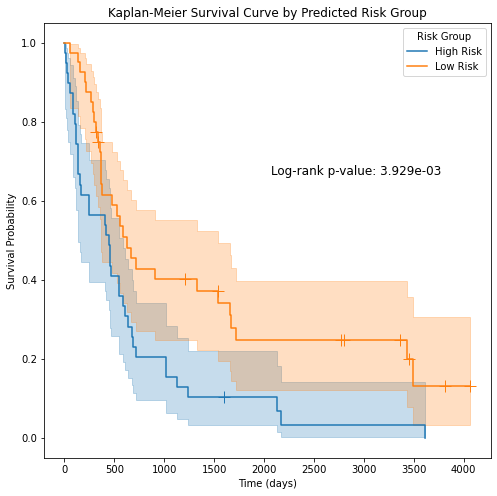

In [109]:
risk_scores = best_model.predict(X_test)
results = pd.DataFrame({
    "risk_score": risk_scores,

    "event": y_test["event"], 
})
threshold = results["risk_score"].median()
results["risk_group"] = np.where(results["risk_score"] > threshold, "High Risk", "Low Risk")

# Log-rank test
high_risk = results[results["risk_group"] == "High Risk"]
low_risk = results[results["risk_group"] == "Low Risk"]
logrank_result = logrank_test(
    high_risk["time"], low_risk["time"], 
    event_observed_A=high_risk["event"], event_observed_B=low_risk["event"]
)
p_value = logrank_result.p_value
print(f"Log-rank test p-value: {logrank_result.p_value}")

kmf = KaplanMeierFitter()
plt.figure(figsize=(8,8))

for group in results["risk_group"].unique():
    group_data = results[results["risk_group"] == group]
    kmf.fit(group_data["time"], group_data["event"], label=group)
    # kmf.plot_survival_function()
    kmf.plot_survival_function(show_censors=True) 
plt.legend(title="Risk Group")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=labels,
    title=f"Risk Group",
    loc="best",
    frameon=True,
)
plt.text(
    0.7, 0.65, f"Log-rank p-value: {p_value:.3e}",
    fontsize=12, transform=plt.gca().transAxes,
    ha="center", bbox=dict(facecolor="white", alpha=0.8, edgecolor="white")
)

plt.title("Kaplan-Meier Survival Curve by Predicted Risk Group")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.show()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=23)
c_index_scores = []

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    model = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=32)
    model.fit(X_train, y_train)
    risk_scores = model.predict(X_test)

    c_index = concordance_index_censored(
        y_test["event"], y_test["time"], risk_scores
    )[0]  
    c_index_scores.append(c_index)
    
    print(f"C-index for fold: {c_index:.3f}")
    if c_index > best_c_index:
        best_c_index = c_index
        best_model = model

average_c_index = np.mean(c_index_scores)
print(f"\nAverage C-index across 5 folds: {average_c_index:.3f}")

print("\nRunning SHAP analysis on the best model...")
explainer = shap.Explainer(best_model.predict, X)  
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

C-index for fold: 0.662
C-index for fold: 0.630
C-index for fold: 0.603
C-index for fold: 0.648
C-index for fold: 0.633

Average C-index across 5 folds: 0.635

Running SHAP analysis on the best model...


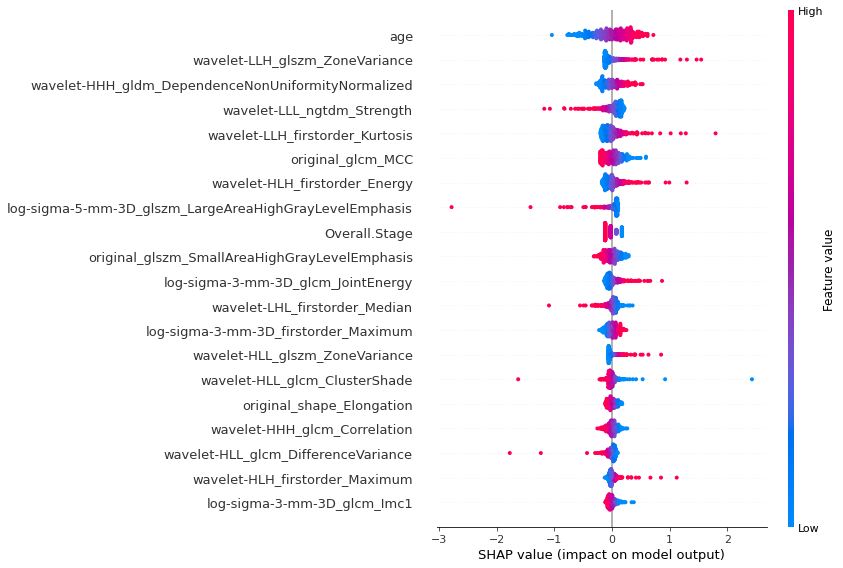

In [70]:
kf = KFold(n_splits=5, shuffle=True, random_state=23)
c_index_scores = []

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    model = CoxnetSurvivalAnalysis(l1_ratio=0.5, alphas=np.logspace(-2, 0, 20), max_iter=10000,)
    model.fit(X_train, y_train)
    risk_scores = model.predict(X_test)
    c_index = concordance_index_censored(
        y_test["event"], y_test["time"], risk_scores
    )[0] 
    c_index_scores.append(c_index)
    
    print(f"C-index for fold: {c_index:.3f}")
    if c_index > best_c_index:
        best_c_index = c_index
        best_model = model

average_c_index = np.mean(c_index_scores)
print(f"\nAverage C-index across 5 folds: {average_c_index:.3f}")

print("\nRunning SHAP analysis on the best model...")
explainer = shap.Explainer(best_model.predict, X) 
shap_values = explainer(X)
plt.figure(figsize=(24, 12))
shap.summary_plot(shap_values, feature_names = selected_X_label,plot_size=(12, 8))

In [71]:
shap_values.shape

(396, 35)